In [3]:
import copy
import pickle

import jax.nn
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpyro
import optax
import tqdm.notebook as tqdm
from numpyro import handlers
from numpyro.infer import autoguide

In [4]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import DataSlice, ToyData1, Sign
from experiments.src.model import BNNRegressor

In [5]:
# %matplotlib inline
# import matplotlib
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,      # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,   # thick lines
    "lines.color": "k",     # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,     # higher resolution output.
})

In [100]:
DEVICE = "gpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 2
VI_MAX_ITER = 100_000
BNN_SIZE = [64, 128, 128, 128, 64]
PRIOR_SCALE = 10.0
BETA = 1.0

In [17]:
VI_LR_SCHEDULE = optax.constant_schedule(-0.0005)
# VI_LR_SCHEDULE = optax.piecewise_interpolate_schedule(
#     interpolate_type='cosine',
#     init_value=-0.1,
#     boundaries_and_scales={1000: 0.2, 5000: 0.5, 10_000: 0.2, 100_000: 0.5, 150_000: 0.5, 200_000: 0.5}
# )

## Data

In [8]:
data = ToyData1(D_X=D_X, train_size=100, sigma_obs=0.05)

## Model

In [101]:
bnn = BNNRegressor(
    nonlin=jax.nn.silu,
    D_X=D_X,
    D_Y=1,
    D_H=BNN_SIZE,
    biases=True,
    prior_scale=PRIOR_SCALE,
    prior_type='xavier',
    # obs_model="classification",
    obs_model='loc_scale',
    # obs_model=1 / (0.05 / 0.26480442)**2,
    beta=BETA,
)


In [102]:
bnn.get_weight_dim()

49922

SWAG experiment

In [103]:
map_experiment = AutoDeltaVIExperiment(bnn, data, num_samples=400, max_iter=VI_MAX_ITER,
                                       lr_schedule=VI_LR_SCHEDULE,
                                       num_particles=1, num_eval_particles=1)

In [110]:
map_experiment.train(random.PRNGKey(0))

Initial eval loss: -51486.7500 (lik: -144.4933, kl: -51631.2422)


100%|██████████| 50/50 [00:06<00:00,  8.07it/s, init loss: -46164.8203, avg. train loss / eval. loss [98-100]: -65792.8594 / -65912.1484]


SVI elapsed time: 6.222455024719238


In [111]:
map_experiment.make_predictions(random.PRNGKey(1))

(-6.0, 6.0)

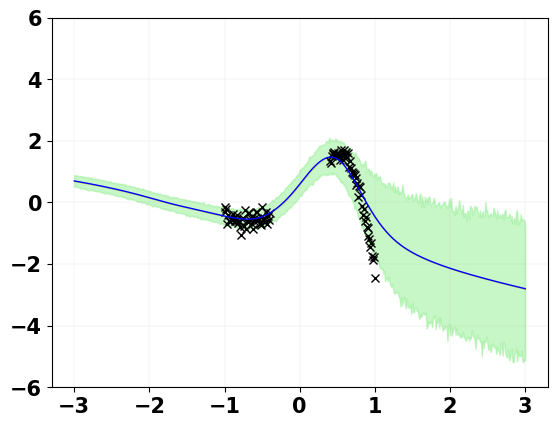

In [112]:
fig, ax = plt.subplots()
map_experiment.make_plots(fig=fig, ax=ax)
ax.set_ylim(-6, 6)
fig.savefig("figs/map.png")

In [75]:
SWAG_LEARNING_RATES = [0.0005, 0.001, 0.002, 0.005, 0.01]
SWAG_MAX_ITER = 10_000

100%|██████████| 10000/10000 [00:26<00:00, 374.45it/s, init loss: -321.5658, avg. loss [9501-10000]: -263.6158]


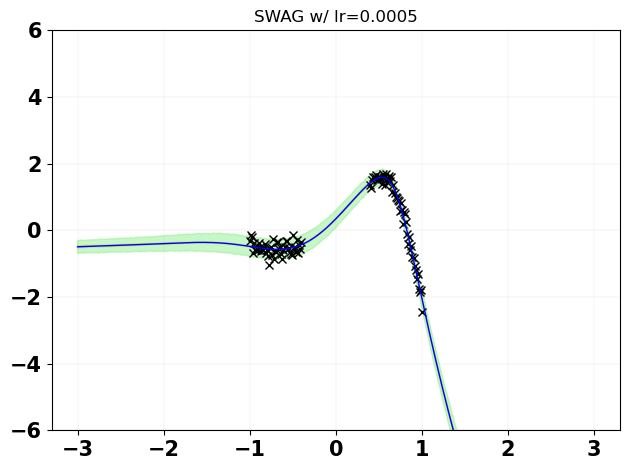

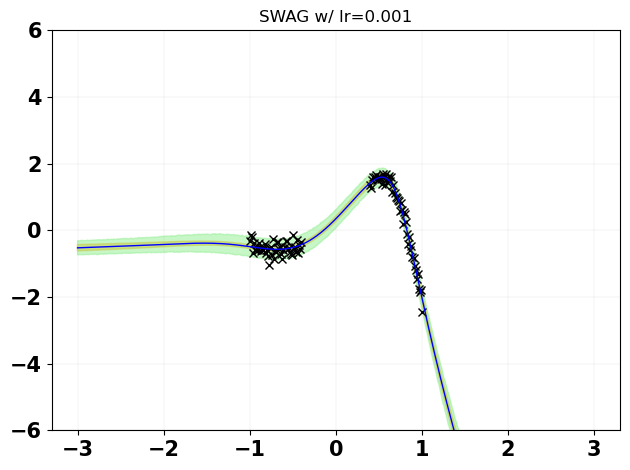

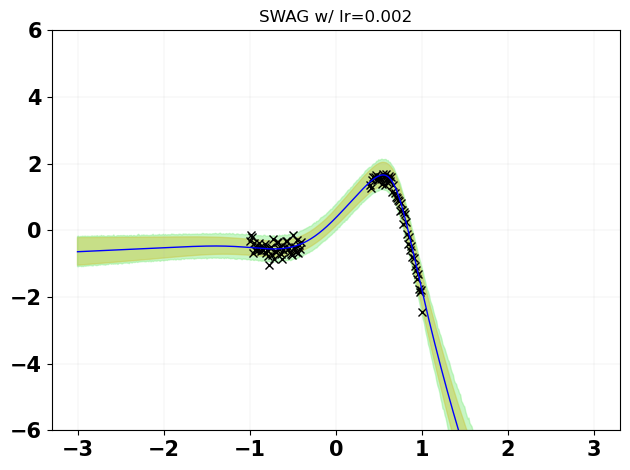

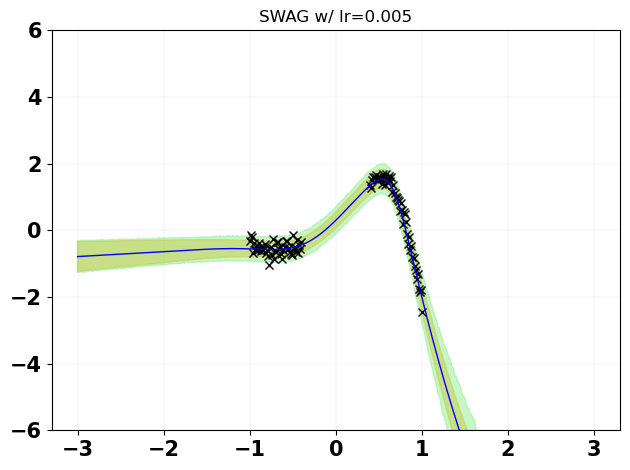

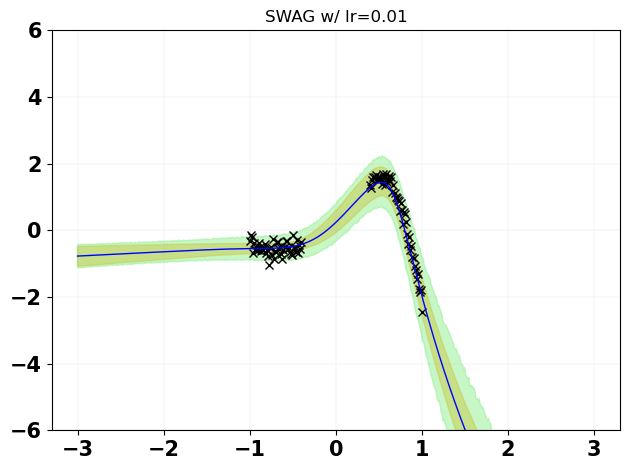

In [76]:
for lr in SWAG_LEARNING_RATES:
    swag_experiment = SWAGExperiment(bnn, data, map_experiment, learning_rate=lr, max_iter=SWAG_MAX_ITER)
    swag_experiment.train(random.PRNGKey(0))
    swag_experiment.make_predictions(random.PRNGKey(1))
    fig, ax = plt.subplots()
    swag_experiment.make_plots(fig=fig, ax=ax)
    ax.set_ylim(-6, 6)
    ax.set_title(f"SWAG w/ lr={lr}")
    fig.tight_layout()
    fig.savefig(f"figs/swag-lr-{lr}.png")